In [2]:
import torch
import numpy as np

import random
import copy
import os
import pickle

import cl_gym as cl
from metrics import MetricCollector2, FairMetricCollector
from configs import make_params

EER_dataset = ["MNIST", "FashionMNIST", "CIFAR10", "CIFAR100"]

In [3]:
LOG_PATH = f"scripts_output"
OUT_PATH = f"outputs"

def is_number(value):
    flag=True
    try:
        num=float(value)
        flag = num == num
    except ValueError:
        flag=False
    return flag


def load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, fair_metric, randinx = False, verbose=2):
    path = f"dataset={dataset}"
    if randinx:
        path+="_randidx"
    # if method != "FSW":
    #     fair_metric = "no_metrics"
    path = os.path.join(path, method)
    path = os.path.join(path, fair_metric)

    # Get log_path
    runs = list()
    for d in os.listdir(os.path.join(LOG_PATH, path)):
        info_dict = dict()
        info_dict['path'] = d
        # print(f"{d=}")
        for elem in d.split("_"):
            k, v = elem.split("=")
            info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
            info_dict['path'] = d
        runs.append(info_dict)

    avails = list()
    for run in runs:
        seed_flag = seed == run.get("seed", None)
        epoch_flag = epoch == run.get("epoch", None)
        lr_flag = lr == run.get("lr", None)
        tau_flag = tau == run.get("tau", 0)
        alpha_flag = alpha == run.get("alpha", 0)
        lmbd_flag = lmbd == run.get("lmbd", 0)
        flag = seed_flag & epoch_flag & lr_flag & tau_flag & alpha_flag & lmbd_flag
        if flag:
            avails.append(run)
    
    if len(avails) == 0:
        if verbose > 2:
            print(runs)
        return False
    target = avails[0]
    
    log_path = os.path.join(path, target['path'])

    out = os.path.join(os.path.join(LOG_PATH, log_path), "log.out")
    err = os.path.join(os.path.join(LOG_PATH, log_path), "log.err")
    if os.path.exists(err):
        with open(err, "r") as f:
            lines = f.readlines()
        if len(lines):
            if verbose:
                print(f"Error in {err} - error during running")
                for line in lines:
                    print(line)
            return False
    else:
        if verbose:
            print(f"error in {os.path.join(LOG_PATH, path)} - not exists")
        return False
    if os.path.exists(out):
        with open(out, "r") as f:
            lines = f.readlines()
        if len(lines) == 0:
            if verbose:
                print(f"{os.path.join(LOG_PATH, path)} - currently running")
            return False
        
    # Get out_path
    runs = list()
    for d in os.listdir(os.path.join(OUT_PATH, path)):
        info_dict = dict()
        info_dict['path'] = d
        # print(f"{d=}")
        for elem in d.split("_"):
            k, v = elem.split("=")
            info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
            info_dict['path'] = d
        runs.append(info_dict)

    avails = list()
    for run in runs:
        seed_flag = seed == run.get("seed", None)
        epoch_flag = epoch == run.get("epoch", None)
        lr_flag = lr == run.get("lr", None)
        tau_flag = tau == run.get("tau", 0)
        alpha_flag = alpha == run.get("alpha", 0)
        lmbd_flag = lmbd == run.get("lmbd", 0)
        flag = seed_flag & epoch_flag & lr_flag & tau_flag & alpha_flag & lmbd_flag
        if flag:
            avails.append(run)
    if len(avails) == 0:
        if verbose > 2:
            print(runs)
        return False
    target = avails[0]
    out_path = os.path.join(path, target['path'])
    return out_path

def print_log(path, option='err'):
    out = os.path.join(os.path.join(LOG_PATH, path), "log.out")
    err = os.path.join(os.path.join(LOG_PATH, path), "log.err")    
    if option == "err":
        if os.path.exists(err):
            with open(out, "r") as f:
                lines = f.readlines()
                print(lines)
    elif option == "out":
        if os.path.exists(out):
            with open(out, "r") as f:
                lines = f.readlines()
                print(lines)

def load_metrics(path, verbose=0):
    metrics_dir = os.path.join(os.path.join(OUT_PATH, path), "metrics/metrics.pickle")
    try:
        with open(metrics_dir, "rb") as f:
            metric_manager_callback = pickle.load(f)
    except:
        print(f"{path} still running")
        return -1

    if verbose>0:
        print(f"{metric_manager_callback.meters.keys()}")
    return metric_manager_callback

In [4]:
def get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, \
             method, randinx = False, verbose=1, metric=None):
    randinx = False
    acc_list = list()
    fair_list = list()
    info_list = list()
    if dataset in EER_dataset:
        disp_metric = "EER"
        metric = "EER"
    else:
        if metric is None:
            disp_metric = "EO"
        else:
            disp_metric = metric
            
    # MNIST
    # if method in ['joint', 'vanilla', 'finetune']:
    if method in ['joint', 'vanilla', 'finetune', 'AGEM', "GSS", "iCaRL", "WA", "OCS"]:
        metric = "no_metrics"
    for tau in tau_range:
        for lr in lr_range:
            for alpha in alpha_range:
                for lmbd in lambda_range:
                    cnt = 0
                    acc_temp = list()
                    acc_std_temp = list()
                    fair_temp = list()
                    fair_std_temp = list()
                    # print(f"{info=}")
                    avail_seed = copy.deepcopy(seed_range)
                    for seed in seed_range:
                        path = load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, metric, randinx=randinx)
                        if not path:
                            if verbose>1:
                                print("Remove")
                                print(f"{dataset=}, {randinx=}, {method=}, {metric=}")
                                print(f"{seed=}, {epoch=}, {lr=}, {tau=}, {alpha=}, {lmbd=}")
                            avail_seed.remove(seed)
                            # print(seed)
                            # print(target_dir)
                            continue
                        mmc = load_metrics(path, verbose=verbose-1)
                        if mmc == -1:
                            continue
                        acc_temp.append(np.mean(mmc.meters['accuracy'].compute_overall()))
                        fair_temp.append(np.mean(mmc.meters[disp_metric].compute_overall()))
                        cnt+=1
                    info = f"lr={lr}_tau={tau}_alpha_{alpha}_lmbd_{lmbd}({cnt=}, {avail_seed})"
                    if cnt == 0:
                        print(f"{info=}: check if boom?")
                        continue
                    else:
                        acc_mean = np.mean(acc_temp)
                        acc_std = np.std(acc_temp)
                        fair_mean = np.mean(fair_temp)
                        fair_std = np.std(fair_temp)
                        info_list.append(info)
                        acc_list.append(acc_mean)
                        fair_list.append(fair_mean)
                        out = f"{info}\nacc:{acc_mean}±{acc_std}\nfair:{fair_mean}±{fair_std}"
                        if verbose:
                            print(out)
    if verbose:
        print()

    # 대충 정한 measure
    # integrated_score = [e - 2*fair_list[i] for i, e in enumerate(acc_list)]
    # print(f"{acc_list=}")
    # idx = integrated_score.index(max(integrated_score))
    # print(f"{info_list[idx]}")
    # accuracy = acc_list[idx]
    # fairness = fair_list[idx]

    # if accuracy > 1:
    #     accuracy /= 100
    # print(f"acc:{accuracy}")
    # print(f"fair:{fairness}")
    return info_list, acc_list, fair_list


In [5]:
import matplotlib.pyplot as plt

def plot(acc_list, fair_list, marker = "o"):
    plt.scatter(acc_list, fair_list, marker=marker, s = 10)
    plt.xlabel('acc')
    plt.ylabel('fairness')

In [28]:
# import os

# pw = "./scripts_output/dataset=BiasedMNIST/WA/no_metrics"
# for f in os.listdir(pw):
#     print(f)
#     new_name = f[:-3]+'0.0'
#     print(new_name)
#     # os.rename(os.path.join(pw, f), os.path.join(pw, new_name))

In [50]:
# DEMO

dataset = "BiasedMNIST"
# dataset = "MNIST"
# dataset = "FashionMNIST"
seed_range = [0, 1, 2, 3, 4]
epoch = 15
# epoch = 5
lr_range = [0.1, 0.01, 0.001]
tau_range = [1.0]
alpha_range = [0.0]
lambda_range = [0.0]
metric="EO"
# metric="DP"
method = "iCaRL"

base_info_list, base_acc_list, base_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric)
# plt.scatter(base_acc_list, base_fair_list, marker='v', s = 20, label="vanilla")


lr=0.1_tau=1.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.8616703333333333±0.002335427488824202
fair:0.052680955555555554±0.0033630465528361702
lr=0.01_tau=1.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.8509143333333332±0.0013414840869557926
fair:0.047531755555555555±0.001168236096550669
lr=0.001_tau=1.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.79847±0.0038052809795511657
fair:0.05022813333333335±0.0014406864917140677



In [52]:
def display(dataset, epoch, size = 20, seed_range=None, metric=None):
    method="joint"
    print(f"{method=}")
    if seed_range is None:
        seed_range = [0, 1, 2, 3, 4]
    tau_range = [0.0]
    alpha_range = [0.0]
    lambda_range = [0.0]

    if dataset in ["MNIST", "FashionMNIST"]:
        lr_range = [0.1, 0.01, 0.001]
    elif dataset in ["BiasedMNIST"]:
        lr_range = [0.001, 0.01]
    elif dataset in ["CIFAR10", "CIFAR100"]:
        lr_range = [0.1, 0.01, 0.001]

    joint_info_list, joint_acc_list, joint_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric)
    plt.scatter(joint_acc_list, joint_fair_list, marker='o', s = size, label=method)

    method="finetune"
    print(f"{method=}")
    tau_range = [0.0]
    alpha_range = [0.0]
    lambda_range = [0.0]
    finetune_info_list, finetune_acc_list, finetune_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric)
    # plt.scatter(finetune_acc_list, finetune_fair_list, marker='x', s = size, label=method)

    method="vanilla"
    print(f"{method=}")
    if dataset in ["MNIST", "FashionMNIST"]:
        tau_range = [1.0, 5.0, 10.0]
        alpha_range = [0.0]
        lr_range = [0.001]
        lambda_range = [0.0]
    elif dataset in ["BiasedMNIST"]:
        tau_range = [1.0, 5.0, 10.0]
        alpha_range = [0.0]
        lambda_range = [0.0]
    elif dataset in ["CIFAR10", "CIFAR100"]:
        tau_range = [1.0, 2.0, 3.0]
        alpha_range = [0.0]
        lambda_range = [0.0]

    base_info_list, base_acc_list, base_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric="no_metrics")
    plt.scatter(base_acc_list, base_fair_list, marker='v', s = size, label=method)

    method="iCaRL"
    print(f"{method=}")
    tau_range = [1.0]
    alpha_range = [0.0]
    lambda_range = [0.0]
    lr_range = [0.1, 0.01, 0.001]
    finetune_info_list, finetune_acc_list, finetune_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric="no_metrics")
    # plt.scatter(finetune_acc_list, finetune_fair_list, marker='x', s = size, label=method)

    method="WA"
    print(f"{method=}")
    tau_range = [0.0]
    alpha_range = [0.0]
    lambda_range = [0.0]
    lr_range = [0.01, 0.001]
    finetune_info_list, finetune_acc_list, finetune_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric="no_metrics")
    # plt.scatter(finetune_acc_list, finetune_fair_list, marker='x', s = size, label=method)

    method="GSS"
    print(f"{method=}")
    tau_range = [1.0, 5.0, 10.0]
    alpha_range = [0.0]
    lambda_range = [0.0]
    lr_range = [0.01, 0.001]
    finetune_info_list, finetune_acc_list, finetune_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric="no_metrics")
    # plt.scatter(finetune_acc_list, finetune_fair_list, marker='x', s = size, label=method)


    method="FSW"
    print(f"{method=}")
    if dataset in ["MNIST", "FashionMNIST"]:
        tau_range = [1.0, 5.0, 10.0, 50.0]
        lr_range = [0.01, 0.001]
        alpha_range = [0.0005, 0.001, 0.002, 0.005, 0.01]
        lambda_range = [0.001, 0.01, 0.1, 1.0]
    elif dataset in ["BiasedMNIST"]:
        tau_range = [1.0, 5.0, 10.0]
        tau_range = [5.0, 10.0]
        lr_range = [0.001]
        alpha_range = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02]
        alpha_range = [0.0005, 0.001, 0.002, 0.005, 0.01]
        lambda_range = [1.0, 5.0, 10.0]
        lambda_range = [5.0, 10.0]
        lambda_range = [1.0, 5.0, 10.0]
        # lambda_range = [1.0]
    elif dataset in ["CIFAR10", "CIFAR100"]:
        tau_range = [1.0, 2.0, 3.0]
        lr_range = [0.1, 0.01, 0.001]
        alpha_range = [0.0005, 0.001, 0.002, 0.005, 0.01]
        lambda_range = [0.1, 0.01]

    fsw_info_list, fsw_acc_list, fsw_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric)
    for i, e in enumerate(fsw_info_list):
        print(e, fsw_acc_list[i], fsw_fair_list[i])
    plt.scatter(fsw_acc_list, fsw_fair_list, marker='x', s = size, label=method)

    target_baseline = [e - 2*base_fair_list[i] for i, e in enumerate(base_acc_list)]
    idx = target_baseline.index(max(target_baseline))
    base_fair_max = base_fair_list[idx]
    base_acc_min = base_acc_list[idx]
    plt.xlim([base_acc_min-0.05, 1])
    plt.ylim([0, base_fair_max+0.05])

    plt.xlabel('acc')
    if dataset in EER_dataset:
        plt.ylabel('eer')
    else:
        if metric is None:
            plt.ylabel('eo')
        else:
            plt.ylabel(metric)
    plt.legend()

    return joint_info_list, joint_acc_list, joint_fair_list, finetune_info_list, finetune_acc_list, finetune_fair_list, base_info_list, base_acc_list, base_fair_list, fsw_info_list, fsw_acc_list, fsw_fair_list

method='joint'
lr=0.1_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.9703609575778975±0.004362576013461739
fair:0.014288581076839169±0.005612058783395619
lr=0.01_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.9695829898232585±0.0003034319559700394
fair:0.012931122506082656±0.0009843316332867104
lr=0.001_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.931365480046261±0.0016149170958988002
fair:0.02995355921181827±0.0013404719118417549

method='finetune'
lr=0.1_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.42879573916452046±0.05028594388574492
fair:0.2925389935991781±0.06430166614257395
lr=0.01_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.4526464958719556±0.0002608591832269024
fair:0.32316813675550327±0.0002837216303431935
lr=0.001_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.45004126571284564±0.00023854700805416387
fair:0.3202340014112309±0.0002589102343465586

method='vanilla'
lr=0.1_tau=1.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1

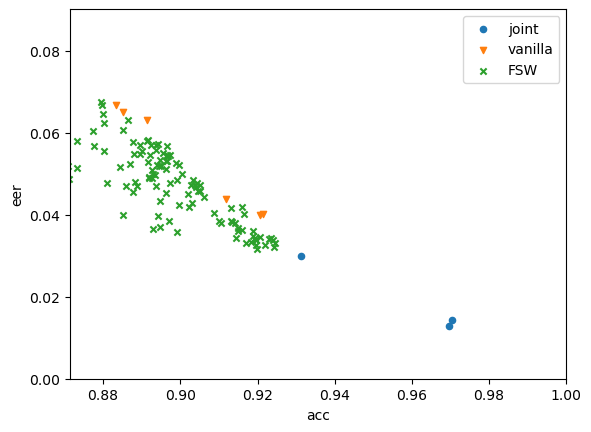

In [55]:
dataset = "MNIST"
epoch = 5
display(dataset, epoch, seed_range=[0, 1, 2, 3, 4], metric="EER")
print()

method='joint'
lr=0.1_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.620383±0.3201396461796008
fair:0.09260092222222223±0.058894645610359835
lr=0.01_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.8953556666666668±0.01042189877133719
fair:0.03525729999999999±0.004023099622013105
lr=0.001_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.8396059999999999±0.0010688340480271502
fair:0.04445804444444444±0.002072228206842704

method='finetune'
lr=0.1_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.24799333333333334±0.03932000000000002
fair:0.16416444444444445±0.00043999999999998484
lr=0.01_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.45048633333333327±0.00024053274205397768
fair:0.3244144111111111±7.49003090534034e-05
lr=0.001_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.4474526666666666±0.00034000751625678024
fair:0.3232861555555555±8.988014927987999e-05

method='vanilla'
lr=0.1_tau=1.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
ac

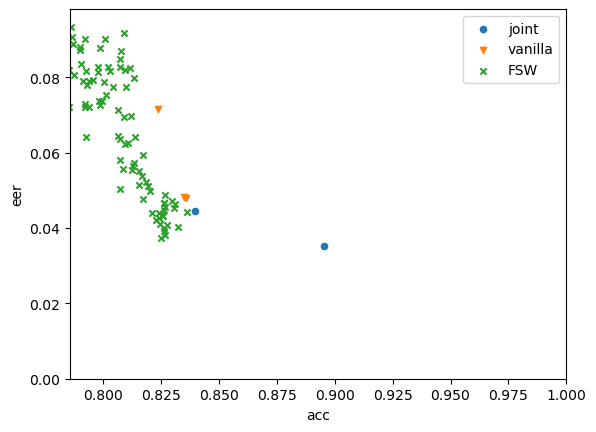

In [56]:
dataset = "FashionMNIST"
epoch = 5
display(dataset, epoch, seed_range=[0, 1, 2, 3, 4], metric="EER")
print()

method='joint'
lr=0.001_tau=0.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.9314123620502816±0.0033960500309529467
fair:0.06669134372137167±0.0028704752754234665

method='finetune'
dataset=BiasedMNIST/finetune/no_metrics/seed=1_epoch=15_lr=0.001_tau=0.0 still running
dataset=BiasedMNIST/finetune/no_metrics/seed=2_epoch=15_lr=0.001_tau=0.0 still running
lr=0.001_tau=0.0_alpha_0.0_lmbd_0.0(cnt=3, [0, 1, 2, 3, 4])
acc:0.44673127739531404±0.0004900310380311759
fair:0.010146749606085357±0.00025465212350375124

method='vanilla'
info='lr=0.001_tau=1.0_alpha_0.0_lmbd_0.0(cnt=0, [])': check if boom?


KeyError: 'no_metrics'

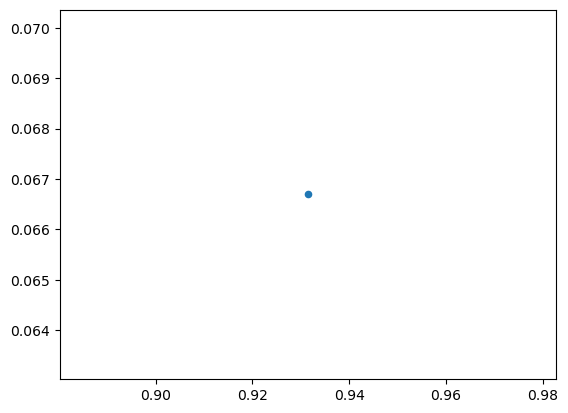

In [59]:
dataset = "BiasedMNIST"
epoch = 15
display(dataset, epoch, seed_range=[0, 1, 2, 3, 4], metric="EO")
print()

In [ ]:
print("gss")
dataset = "MNIST"
epoch = 1
tau_range = [1.0, 5.0, 10.0]
alpha_range = [0.0]
lr_range = [0.01, 0.001]
lambda_range = [0.0]
seed_range = [0, 1, 2]

base_info_list, base_acc_list, base_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)
plt.scatter(base_acc_list, base_fair_list, marker='v', s = 10)


In [ ]:
tau_range = [1.0, 5.0, 10.0]
lr_range = [0.01, 0.001]
alpha_range = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02]
lambda_range = [1.0, 5.0, 10.0]
seed_range = [0, 1, 2, 3, 4]


info_list, acc_list, fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)
plot(acc_list, fair_list)

In [ ]:
tau_range = [1.0, 5.0, 10.0]
lr_range = [0.01, 0.001]
alpha_range = [0.0]
lambda_range = [1.0, 5.0, 10.0]
seed_range = [0, 1, 2, 3, 4]

info_list, acc_list, fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)
plot(acc_list, fair_list)

In [ ]:
tau_range = [0.0]
lr_range = [0.01, 0.001]
alpha_range = [0.0]
seed_range = [0, 1, 2, 3, 4]

info_list, acc_list, fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, joint=True)
plot(acc_list, fair_list)

In [ ]:
tau_range = [1.0, 5.0, 10.0]
lr_range = [0.01, 0.001]
alpha_range = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02]
lambda_range = [1.0, 5.0, 10.0]
seed_range = [0, 1, 2, 3, 4]

dataset = "FashionMNIST"
epoch = 1
lmbd = 1.0

info_list, acc_list, fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)

In [ ]:
tau_range = [1.0, 5.0, 10.0]
lr_range = [0.01, 0.001]
alpha_range = [0.0]
lambda_range = [1.0, 5.0, 10.0]
seed_range = [0, 1, 2, 3, 4]

dataset = "FashionMNIST"
epoch = 1
lmbd = 1.0

info_list, acc_list, fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)